## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

not found
not found
not found


error: /feedstock_root/build_artefacts/opencv_1496434080029/work/opencv-3.2.0/modules/highgui/src/window.cpp:577: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvDestroyAllWindows


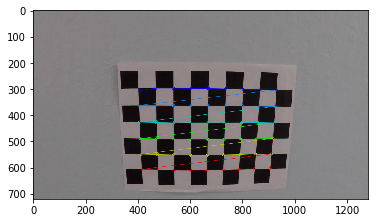

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d points in real world space
img_points = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret:
        #print('found the corners')
        obj_points.append(objp)
        img_points.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        #cv2.waitKey(500)
    else:
        print('not found')

cv2.destroyAllWindows()

## Now applying distortion correction to the row image

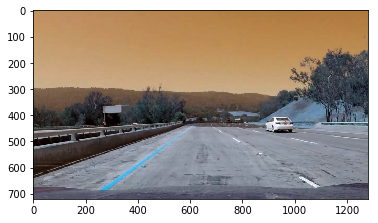

In [4]:
def remove_distortion(img, obj_points, img_points):
    #print('inside remove distotion')
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    #ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    un_dst = cv2.undistort(img, mtx, dist, None, mtx)
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(un_dst)
    #ax2.set_title('Undistorted Image', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #plt.savefig('un_distorted_real.png')
    #plt.show()
    return dist, mtx, un_dst

#org_img = cv2.imread('../test_images/straight_lines1.jpg')
#img = cv2.imread('../camera_cal/calibration1.jpg')
#org_img = cv2.imread('../test_images/test5.jpg')
org_img = cv2.imread('not_working.jpg')
plt.imshow(org_img)
dist, mtx, un_dst = remove_distortion(org_img, obj_points, img_points)


## Applying color and gradient transform to the image

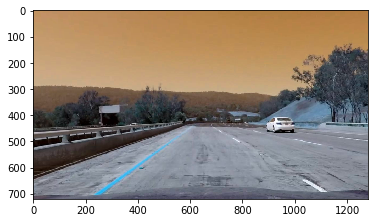

In [5]:
def gradient_color_transform(img, s_thresh=(170, 255), sx_thresh=(30, 80)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1


     #Plotting thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#     ax1.set_title('Stacked thresholds')
#     ax1.imshow(color_binary)

#     ax2.set_title('Combined S channel and gradient thresholds')
#     ax2.imshow(combined_binary, cmap='gray')
#     plt.imshow(combined_binary, cmap='gray')
#     plt.savefig('binary_combo_real.png')
#     plt.savefig('../combined_image.jpg')
    return combined_binary


image = un_dst
#image = cv2.imread('../test_images/test1.jpg')
plt.imshow(image)
plt.show()
combined_image = gradient_color_transform(image)


## Applying perspective transform

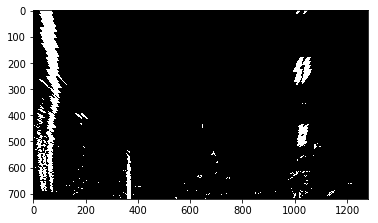

In [32]:
def transform(cur, dist, mtx):
    #img = np.copy(cur)
    img = cur
    #print(img.shape)
    un_dst = cv2.undistort(img, mtx, dist, None, mtx)
    #plt.imshow(un_dst)
    #plt.show()
    #print(un_dst.shape)
    img_size = (img.shape[1], img.shape[0])

    src = np.float32([[200, img_size[1] - 1], [595, 450], [685, 450], [1100, img_size[1] - 1]])
    dst = np.float32([[350, img_size[1] - 1],
                      [350, 1],
                      [970, 1],
                      [970, img_size[1] - 1]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(un_dst, M, img_size)
    
    color=[255, 0, 0] 
    thickness=5
#     cv2.line(img, (200, img_size[1] - 1), (590, 450), color, thickness)
#     cv2.line(img, (590, 450), (690, 450), color, thickness)
#     cv2.line(img, (690, 450), (1100, img_size[1] - 1), color, thickness)
#     cv2.line(img, (1100, img_size[1] - 1), (300, img_size[1] - 1), color, thickness)
    
#     cv2.line(warped, (350, img_size[1] - 1), (350, 1), color, thickness)
#     cv2.line(warped, (350, 1), (970,  1), color, thickness)
#     cv2.line(warped, (970, 1), (970, img_size[1] - 1), color, thickness)
#     cv2.line(warped, (970, img_size[1] - 1), (350, img_size[1] - 1), color, thickness)
    
    
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,9))
#     f.tight_layout()
#     ax1.imshow(img)
#     ax1.set_title('Un-distorted Image with source points', fontsize=50)
#     ax2.imshow(warped)
#     ax2.set_title('Warped Image with destination', fontsize=50)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     plt.savefig('warped_straight_lines_real.png')
#     plt.show()
    return warped, Minv

#combined_image = cv2.cvtColor(mpimg.imread('../test_images/straight_lines1.jpg'), cv2.COLOR_RGB2GRAY)
#combined_image = mpimg.imread('../binary-combo-img.jpg')
plt.imshow(combined_image, cmap='gray')
binary_warped, Minv = transform(combined_image, dist, mtx)
plt.imshow(binary_warped, cmap='gray')

## Detecting lane  And Finding the curvature

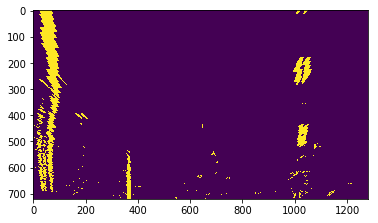

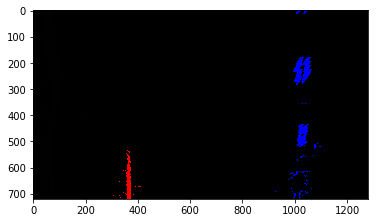

In [39]:
def getCurvature_and_center_of_line(leftx, lefty, rightx, righty, y_eval, shape):
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Generate x and y values for plotting
    #print(y_eval, left_fit, right_fit)
    
    y_eval_meters = y_eval * ym_per_pix
    
    left_bottom = left_fit[0] * y_eval_meters ** 2 + left_fit[1] * y_eval_meters + left_fit[2]
    right_bottom = right_fit[0] * y_eval_meters ** 2 + right_fit[1] * y_eval_meters + right_fit[2]
    line_center = (left_bottom + right_bottom) / 2
    img_center = shape[1] /2 * xm_per_pix
    dif = img_center - line_center
    #print('curvature left ', left_bottom, 'right',right_bottom, 'line_center ', line_center, img_center, dif)
        
    
    left_curvature = ((1 + (2 * left_fit[0] * y_eval *ym_per_pix  + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curvature = ((1 + (2 * right_fit[0] * y_eval  *ym_per_pix  + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    
    mean_curvature = (left_curvature + right_curvature) /2
    
    return mean_curvature, dif


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    left_margin = 300 #to avoid wrong identification of dividers as lines
    leftx_base = left_margin + np.argmax(histogram[left_margin:midpoint])
    #print('leftx_base', leftx_base, midpoint)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(leftx_base,rightx_base)
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    # print('non-zero', len(nonzero[0]), len(nonzero[1]))
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        ### TO-DO: Find the four below boundaries of the window ###

        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this

        # Draw the windows on the visualization image
#         cv2.rectangle(out_img, (win_xleft_low, win_y_low),
#                       (win_xleft_high, win_y_high), (0, 255, 0), 2)
#         cv2.rectangle(out_img, (win_xright_low, win_y_low),
#                      (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzerox > win_xleft_low) & (nonzerox < win_xleft_high) & (nonzeroy < win_y_high) & (
                    nonzeroy > win_y_low)).nonzero()[0]
        good_right_inds = ((nonzerox > win_xright_low) & (nonzerox < win_xright_high) & (nonzeroy < win_y_high) & (
                    nonzeroy > win_y_low)).nonzero()[0]

        # Append these indices to the lists
        if (good_left_inds.shape[0] != 0):
            left_lane_inds.append(good_left_inds)
        if (good_right_inds.shape[0] != 0):
            right_lane_inds.append(good_right_inds)
        #print(win_y_low,good_left_inds.shape)
        #(`right` or `leftx_current`) on their mean position #
        try:
            if (len(good_left_inds) > minpix):
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        except:
            pass
    #print(len(left_lane_inds),'l eft ', len(right_lane_inds))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print(leftx.shape, lefty.shape, rightx.shape, righty.shape)
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print('left fit', left_fit, right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1 * ploty ** 2 + 1 * ploty
        right_fitx = 1 * ploty ** 2 + 1 * ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    y_eval = np.max(ploty)
    mean_curvature, center_to_image = getCurvature_and_center_of_line(leftx, lefty, rightx, righty, y_eval, out_img.shape)
    #Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    lines_mid = (left_fitx[-1] + right_fitx[-1]) //2
    
    return out_img, left_fitx, right_fitx, ploty, mean_curvature, center_to_image


plt.imshow(binary_warped)
plt.show()
warped_line_detected_box_method,  left_fitx, right_fitx, ploty, mean_curvature, center_to_image = fit_polynomial(binary_warped)
plt.imshow(warped_line_detected_box_method)
plt.show()
#plt.savefig('warped_line_detected_box_method.png')


## Warp line back into the original image

In [40]:

def transform_back_add_text(binary_warped, left_fitx, right_fitx, ploty, org_img, mean_curvature, center_to_image ):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(np.int_(pts).shape)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)

    newwarp = cv2.warpPerspective(color_warp, Minv, (org_img.shape[1], org_img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(org_img, 1, newwarp, 0.3, 0)
    
    
    direction =  'left' if center_to_image < 0 else 'right'
    string_direction = 'Vehicle is %.2fm' %abs(center_to_image)+' '+direction+' to the center'
    string_mean_curvature = 'Radius of Curvature %.2f(m)' %mean_curvature   
    
    cv2.putText(result,string_mean_curvature, (100,50), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2)
    cv2.putText(result,string_direction, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2)
    #cv2.imshow(result)
    #plt.imshow(result)
    return result
    
final_image = transform_back_add_text(binary_warped, left_fitx, right_fitx, ploty,org_img, mean_curvature, center_to_image)    
#plt.imshow(final_image)


## Pipeline for video

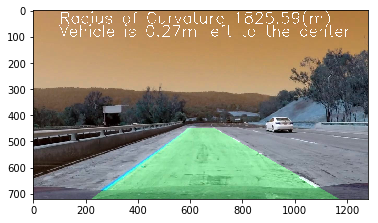

In [41]:
def pipeline(image):
    dist, mtx, un_dst = remove_distortion(image, obj_points, img_points)
    combined_image = gradient_color_transform(un_dst)
    binary_warped, Minv = transform(combined_image, dist, mtx)
    warped_line_detected_box_method,  left_fitx, right_fitx, ploty, mean_curvature, center_to_image = fit_polynomial(binary_warped)
    final_image = transform_back_add_text(binary_warped, left_fitx, right_fitx, ploty,image, mean_curvature, center_to_image)
    #plt.imshow(final_image)
    #print(final_image.shape)
    return final_image

org_img = cv2.imread('not_working.jpg')
res = pipeline(org_img)    
plt.imshow(res)
plt.show()
#org_img = cv2.imread('../test_images/test1.jpg')
#res = pipeline(org_img)    
#plt.imshow(res)
#plt.show()
    

In [42]:
def process_image(image):
    return pipeline(image)

In [43]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
video_output = '../harder_challenge_video_output_copy1.mp4'
video_input = "../harder_challenge_video.mp4"
clip1 = VideoFileClip(video_input)
print(clip1.duration)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#clip1.reader.close()
#clip1.audio.reader.close_proc()

%time white_clip.write_videofile(video_output, audio=False)

47.96
[MoviePy] >>>> Building video ../harder_challenge_video_output_copy1.mp4
[MoviePy] Writing video ../harder_challenge_video_output_copy1.mp4


100%|█████████▉| 1199/1200 [13:04<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../harder_challenge_video_output_copy1.mp4 

CPU times: user 10min 3s, sys: 21.3 s, total: 10min 24s
Wall time: 13min 8s


In [47]:
#print(white_clip)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

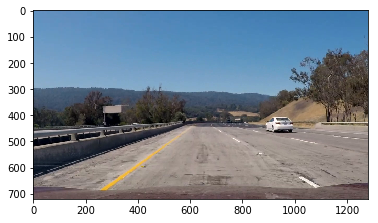

In [124]:
video = VideoFileClip('../project_video.mp4')
np_frame = video.get_frame(23)
plt.imshow(np_frame)
#plt.savefig('not_working.jpg')
video.save_frame('not_working.jpg', t=23) 